In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Set up plotting styles
sns.set_style("whitegrid")
%matplotlib inline

# Define paths to data files based on the project structure
data_path = "../data/"
fraud_data_path = data_path + "Fraud_Data.csv"
ip_data_path = data_path + "IpAddress_to_Country.csv"
creditcard_data_path = data_path + "creditcard.csv"

print("Libraries imported and data paths defined.")

Libraries imported and data paths defined.


In [5]:
# Load the three datasets
try:
    df_fraud = pd.read_csv(fraud_data_path)
    df_ip = pd.read_csv(ip_data_path)
    df_creditcard = pd.read_csv(creditcard_data_path)
    
    print("Datasets loaded successfully.")
    
    # Display the first few rows of each dataframe to verify
    print("\nFraud_Data.csv head:")
    print(df_fraud.head())
    print("\nIpAddress_to_Country.csv head:")
    print(df_ip.head())
    print("\ncreditcard.csv head:")
    print(df_creditcard.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data files are in the 'data' directory.")

Datasets loaded successfully.

Fraud_Data.csv head:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  

IpAddress_to_Country.csv head:
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0             

In [6]:
# Check for missing values
print("Missing values in Fraud_Data.csv:")
print(df_fraud.isnull().sum())

Missing values in Fraud_Data.csv:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


In [7]:
# Convert 'signup_time' and 'purchase_time' to datetime objects
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

print("\nData types after conversion:")
print(df_fraud.info())


Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB
None


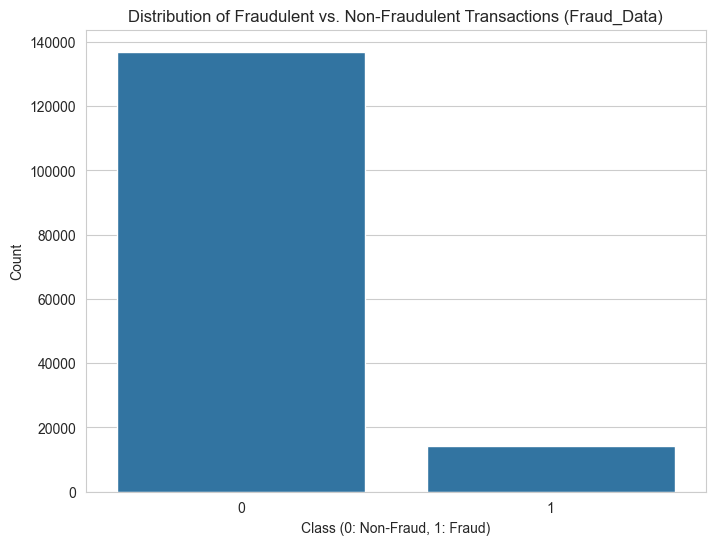

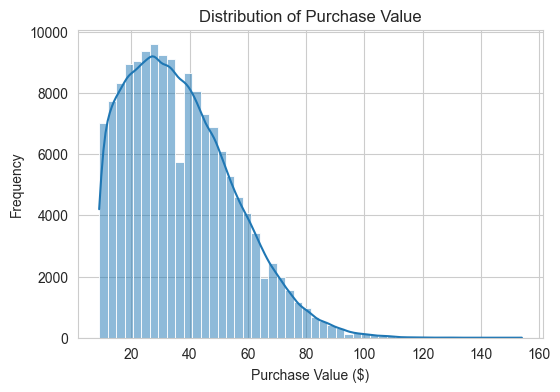

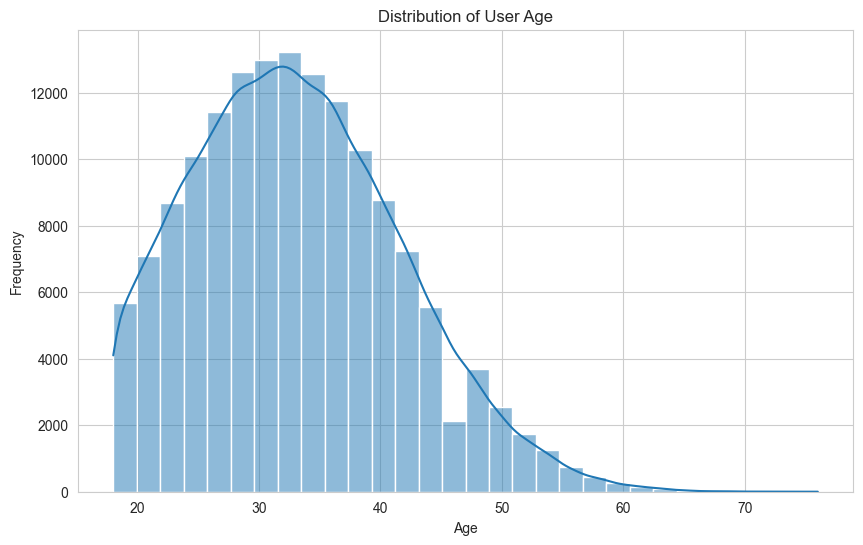

In [8]:
# Class distribution (critical challenge)
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df_fraud)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions (Fraud_Data)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Distribution of 'purchase_value'
plt.figure(figsize=(6,4))
sns.histplot(df_fraud['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value ($)')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'age'
plt.figure(figsize=(10, 6))
sns.histplot(df_fraud['age'], bins=30, kde=True)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

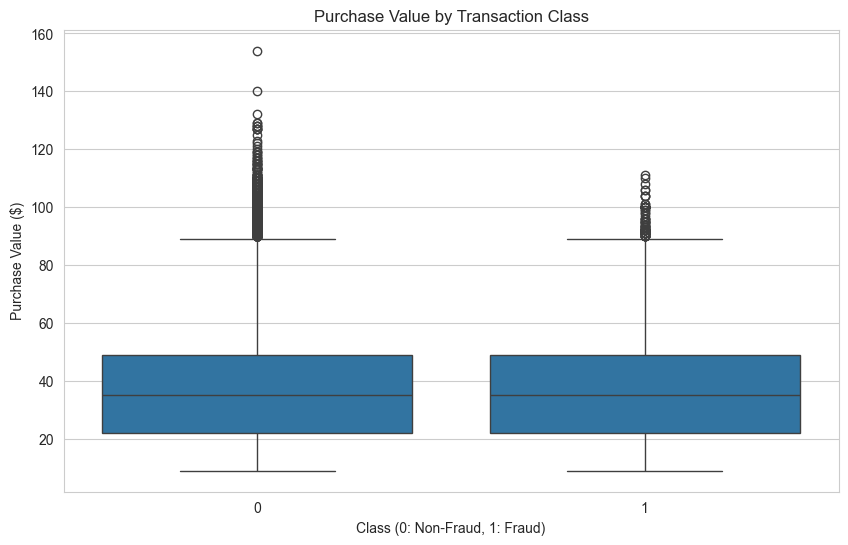

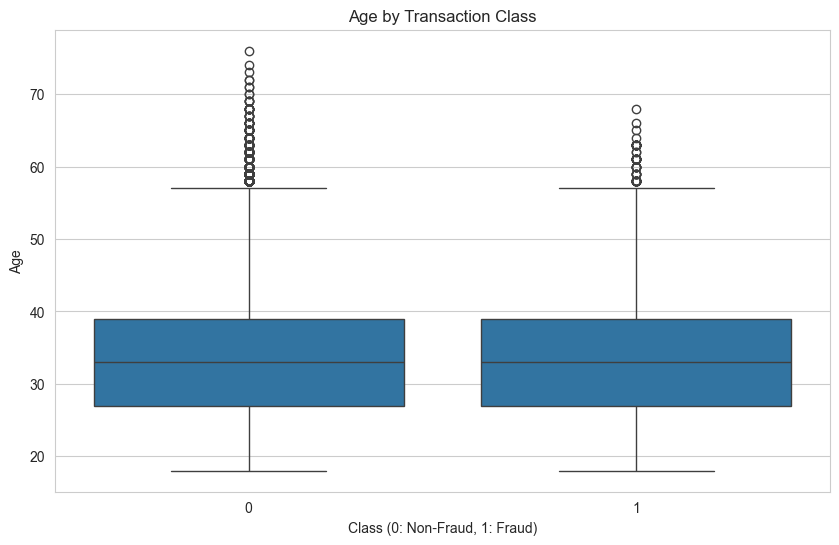

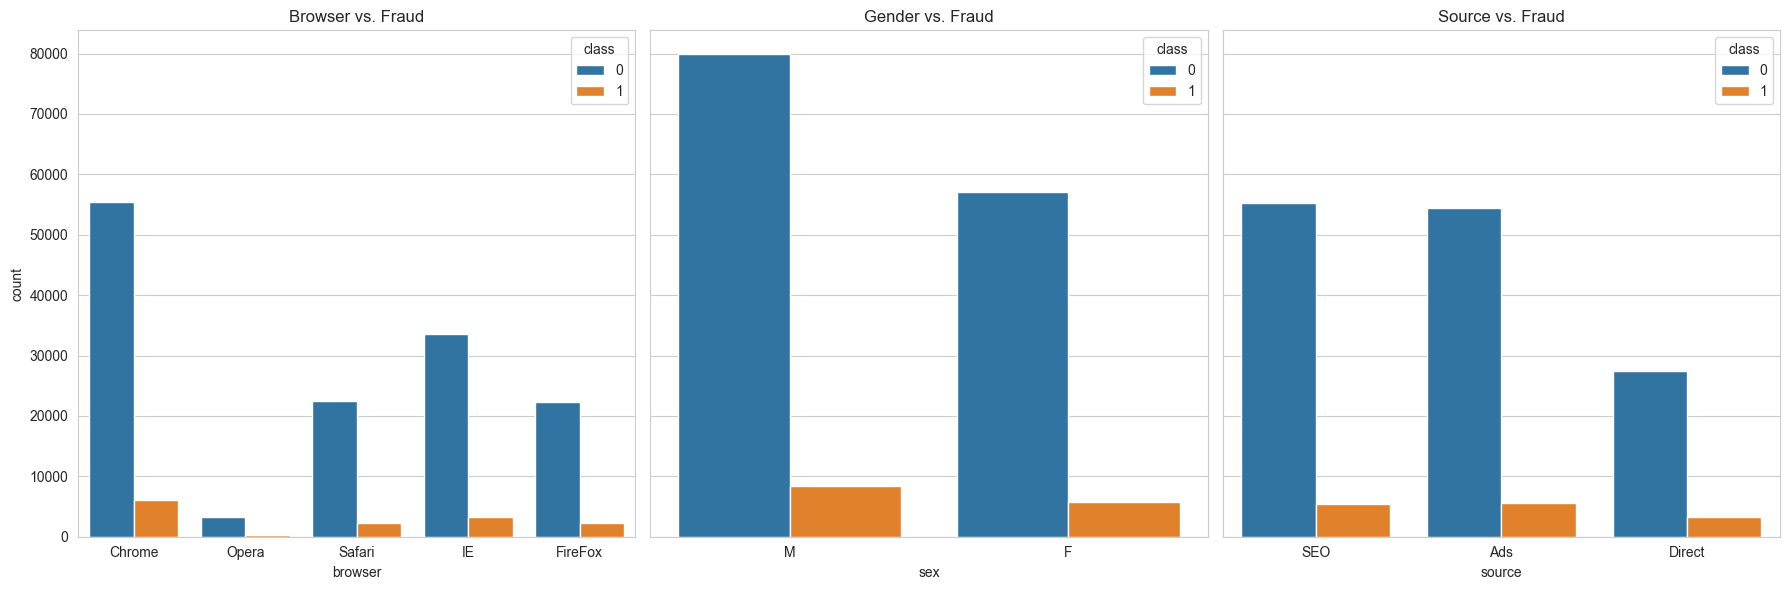

In [16]:
# Purchase value distribution for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df_fraud)
plt.title('Purchase Value by Transaction Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Purchase Value ($)')
plt.show()

# Age distribution for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='age', data=df_fraud)
plt.title('Age by Transaction Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Age')
plt.show()

# Categorical features vs. fraud
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.countplot(x='browser', hue='class', data=df_fraud, ax=axes[0])
axes[0].set_title('Browser vs. Fraud')
sns.countplot(x='sex', hue='class', data=df_fraud, ax=axes[1])
axes[1].set_title('Gender vs. Fraud')
sns.countplot(x='source', hue='class', data=df_fraud, ax=axes[2])
axes[2].set_title('Source vs. Fraud')
plt.tight_layout()
plt.show()

In [17]:
import ipaddress # Keep this for standard IP parsing

# Assuming df_fraud and df_ip are already loaded

def ip_to_int(ip_address_val):
    """
    Converts an IP address to a 32-bit integer.
    Handles dotted decimal strings, integer-like floats, and NaNs.
    Prioritizes converting numerical strings/floats to integers.
    """
    if pd.isna(ip_address_val):
        return np.nan

    # Try to convert to float first. This will catch '732758368.79972'
    # and turn it into the float 732758368.79972.
    try:
        numeric_ip = float(ip_address_val)
        # If it's successfully converted to a float, assume it's a numeric IP
        # and truncate the decimal part by converting to int.
        return int(numeric_ip)
    except ValueError:
        # If it's not directly convertible to a float, it might be a standard
        # dotted-decimal IP string (e.g., "192.168.1.1").
        try:
            # Use the ipaddress module for proper validation and conversion
            return int(ipaddress.ip_address(str(ip_address_val)))
        except (ipaddress.AddressValueError, ValueError):
            # This catches both invalid IP formats from ipaddress and other ValueErrors
            print(f"Warning: Could not convert IP address '{ip_address_val}' to integer. Returning NaN.")
            return np.nan

# --- Apply to DataFrames ---
# It's still good practice to ensure they are string objects for consistency
# and to avoid pandas type inference issues, even if the function can handle numbers.
df_fraud['ip_address'] = df_fraud['ip_address'].astype(str)
df_fraud['ip_address_int'] = df_fraud['ip_address'].apply(ip_to_int)

df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype(str)
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype(str)
df_ip['lower_bound_ip_int'] = df_ip['lower_bound_ip_address'].apply(ip_to_int)
df_ip['upper_bound_ip_int'] = df_ip['upper_bound_ip_address'].apply(ip_to_int)

print("\nIP addresses converted to integers (with robust handling of float-like strings).")

# --- Sample and merge (as you had it) ---
# Note: For accurate results on the merge, you should ideally convert the *entire* df_fraud
# rather than just a sample, and then perform the merge.
# For demonstration purposes, your sampling might be okay, but be mindful of data loss.
df_fraud_sample = df_fraud.sample(n=1000, random_state=42)

# Ensure df_ip has the 'lower_bound_ip_int' and 'upper_bound_ip_int' columns fully populated
# (apply ip_to_int to the full df_ip before passing it to find_country)
# And the find_country function relies on these numeric ranges.

# Define find_country if not already defined (or ensure it's in scope)
def find_country(ip_int, df_ip_ranges):
    """Finds the country for a given IP address integer."""
    if pd.isna(ip_int):
        return 'Unknown'
    country = df_ip_ranges[(df_ip_ranges['lower_bound_ip_int'] <= ip_int) &
                           (df_ip_ranges['upper_bound_ip_int'] >= ip_int)]['country']
    if not country.empty:
        return country.iloc[0]
    return 'Unknown'


df_fraud_sample['country'] = df_fraud_sample['ip_address_int'].apply(find_country, df_ip_ranges=df_ip)

# Display the result
print(df_fraud_sample[['ip_address', 'ip_address_int', 'country', 'class']].head())

# Check for any NaNs introduced due to conversion issues (e.g., bad IP formats)
print("\nMissing values in new IP integer columns after improved conversion:")
print(df_fraud['ip_address_int'].isnull().sum())
print(df_ip['lower_bound_ip_int'].isnull().sum())
print(df_ip['upper_bound_ip_int'].isnull().sum())


IP addresses converted to integers (with robust handling of float-like strings).
              ip_address  ip_address_int            country  class
92865   3315147387.22793      3315147387            Morocco      0
50746   991628325.615216       991628325  Korea Republic of      0
128421  274442709.665377       274442709      United States      0
146243  2654816479.51674      2654816479      United States      1
44524   1419979966.38594      1419979966            Germany      0

Missing values in new IP integer columns after improved conversion:
0
0
0


In [18]:
# Assuming df_fraud and df_ip (with 'lower_bound_ip_int', 'upper_bound_ip_int' populated) are ready

# If you only applied to sample before, apply to the full dataframe now:
print("Applying country lookup to the full df_fraud. This might take a while...")
df_fraud['country'] = df_fraud['ip_address_int'].apply(find_country, df_ip_ranges=df_ip)
print("Country lookup complete for full df_fraud.")

# Verify a few entries with country
print(df_fraud[['ip_address', 'ip_address_int', 'country', 'class']].head())
print(f"Number of 'Unknown' countries: {df_fraud[df_fraud['country'] == 'Unknown'].shape[0]}")

Applying country lookup to the full df_fraud. This might take a while...
Country lookup complete for full df_fraud.
         ip_address  ip_address_int        country  class
0   732758368.79972       732758368          Japan      0
1  350311387.865908       350311387  United States      0
2  2621473820.11095      2621473820  United States      1
3  3840542443.91396      3840542443        Unknown      0
4  415583117.452712       415583117  United States      0
Number of 'Unknown' countries: 21966


In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Keep this for now to suppress other warnings if any

# Assuming df_fraud is loaded and 'purchase_time' is a datetime object
# And country data has been merged

# --- Time-Based Features (Recap & Re-run to ensure consistency) ---
df_fraud['hour_of_day'] = df_fraud['purchase_time'].dt.hour
df_fraud['day_of_week'] = df_fraud['purchase_time'].dt.day_name()
df_fraud['month_of_year'] = df_fraud['purchase_time'].dt.month
df_fraud['day_of_year'] = df_fraud['purchase_time'].dt.dayofyear

# Calculate time_since_signup (in hours)
df_fraud['time_since_signup'] = (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds() / 3600

original_index = df_fraud.index

# Sort by group ID and then by time for each group
df_fraud.sort_values(by=['user_id', 'purchase_time'], inplace=True)

# Function to calculate rolling features within a group, preserving original index
def calculate_rolling_features_robust(group_df, time_col, window_size):
    # Ensure the group is sorted by time (important for rolling)
    group_df = group_df.sort_values(by=time_col)
    
    # Create a Series for rolling, with the original index and time column as values
    # The rolling function needs a datetime-like index to use '24H' etc.
    # We will use the 'purchase_time' as the index for the rolling calculation itself.
    # The result will have the 'purchase_time' as its index.
    rolling_result = group_df.set_index(time_col).rolling(window_size)['purchase_value'].count() - 1
    
    aligned_results = pd.Series(rolling_result.values, index=group_df.index)
    
    return aligned_results

# Apply to user_id
# The .apply() method on a grouped object will return a Series where the index
# is a MultiIndex of (user_id, original_index).
# We then use .droplevel(0) to remove the user_id part of the MultiIndex,
# leaving only the original_index, which allows for direct assignment.
df_fraud['user_transactions_24h'] = df_fraud.groupby('user_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '24H')
)

df_fraud['user_transactions_7d'] = df_fraud.groupby('user_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '7D')
)

# Sort by device_id and then by time for each group
df_fraud.sort_values(by=['device_id', 'purchase_time'], inplace=True)

# Apply to device_id
df_fraud['device_transactions_24h'] = df_fraud.groupby('device_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '24H')
)

df_fraud['device_transactions_7d'] = df_fraud.groupby('device_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '7D')
)

# Ensure the DataFrame is sorted back by its original index if needed for later steps
# df_fraud = df_fraud.loc[original_index].copy() # This might be useful if order matters for subsequent ops

print("\nEngineered features added to df_fraud:")
print(df_fraud[['purchase_time', 'time_since_signup', 'hour_of_day', 'day_of_week',
                'user_transactions_24h', 'device_transactions_24h', 'country']].head())

# Check for NaNs that might be introduced by rolling operations (e.g., first few transactions)
print("\nMissing values after feature engineering (rolling features):")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].isnull().sum())

# Fill NaNs created by rolling features (they will be 0 for the first transaction in a group)
for col in ['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']:
    df_fraud[col].fillna(0, inplace=True)

print("\nMissing values after filling NaNs:")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].isnull().sum())

# Ensure dtypes are integer after filling NaNs if appropriate
df_fraud['user_transactions_24h'] = df_fraud['user_transactions_24h'].astype(int)
df_fraud['device_transactions_24h'] = df_fraud['device_transactions_24h'].astype(int)
df_fraud['user_transactions_7d'] = df_fraud['user_transactions_7d'].astype(int)
df_fraud['device_transactions_7d'] = df_fraud['device_transactions_7d'].astype(int)

print("\nData types after feature engineering:")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].dtypes)


Engineered features added to df_fraud:
            purchase_time  time_since_signup  hour_of_day day_of_week  \
34321 2015-06-13 23:42:18         775.696389           23    Saturday   
57616 2015-03-29 00:39:07        1226.317500            0      Sunday   
46520 2015-07-22 03:18:01        1754.468889            3   Wednesday   
69175 2015-01-01 04:25:23           0.000278            4    Thursday   
35860 2015-01-01 04:25:24           0.000278            4    Thursday   

       user_transactions_24h  device_transactions_24h         country  
34321                    0.0                      0.0  United Kingdom  
57616                    0.0                      0.0   United States  
46520                    0.0                      0.0         Unknown  
69175                    0.0                      0.0  United Kingdom  
35860                    0.0                      1.0  United Kingdom  

Missing values after feature engineering (rolling features):
user_transactions_24h      

In [23]:

import warnings
warnings.filterwarnings('ignore')

print("\n--- Data Transformation for Fraud_Data.csv ---")

# Drop original time columns (already extracted features from them)
# Drop IDs as they are not direct features for the model (used for grouping/merging)
# Keep 'ip_address_int' as a numerical feature.
X_fraud = df_fraud.drop([
    'class',
    'signup_time',
    'purchase_time',
    'ip_address', # Original string IP, 'ip_address_int' is the feature
    'user_id',    # Used for feature engineering, not direct model input
    'device_id'   # Used for feature engineering, not direct model input
], axis=1)
y_fraud = df_fraud['class']
print(X_fraud.head())
print(y_fraud.head())

print(f"Features (X_fraud) shape: {X_fraud.shape}")
print(f"Target (y_fraud) shape: {y_fraud.shape}")

# 1.2 Split Data into Training and Testing Sets
# Stratify to maintain class distribution in both train and test sets
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print("\nFraud_Data split into training and testing sets:")
print(f"X_train_fraud shape: {X_train_fraud.shape}, y_train_fraud shape: {y_train_fraud.shape}")
print(f"X_test_fraud shape: {X_test_fraud.shape}, y_test_fraud shape: {y_test_fraud.shape}")
print(f"Training set class distribution:\n{y_train_fraud.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test_fraud.value_counts(normalize=True)}")


--- Data Transformation for Fraud_Data.csv ---
       purchase_value  source  browser sex  age  ip_address_int  \
34321              45  Direct   Chrome   M   34      2494581089   
57616              94     Ads   Chrome   M   29       809263681   
46520              46     Ads       IE   M   40         2891496   
69175              57     Ads  FireFox   F   36      1377849233   
35860              57     Ads  FireFox   F   36      1377849233   

              country  hour_of_day day_of_week  month_of_year  day_of_year  \
34321  United Kingdom           23    Saturday              6          164   
57616   United States            0      Sunday              3           88   
46520         Unknown            3   Wednesday              7          203   
69175  United Kingdom            4    Thursday              1            1   
35860  United Kingdom            4    Thursday              1            1   

       time_since_signup  user_transactions_24h  user_transactions_7d  \
34321  

In [24]:
# 2.1 Identify Numerical and Categorical Features for Pipeline
numerical_features_fraud = [
    'purchase_value', 'age', 'time_since_signup',
    'user_transactions_24h', 'device_transactions_24h',
    'user_transactions_7d', 'device_transactions_7d',
    'hour_of_day', 'month_of_year', 'day_of_year',
    'ip_address_int'
]
categorical_features_fraud = [
    'source', 'browser', 'sex', 'day_of_week', 'country'
]

# Verify all features exist in the DataFrame
# This check is important, especially after feature engineering and dropping columns
missing_numerical = [col for col in numerical_features_fraud if col not in X_train_fraud.columns]
missing_categorical = [col for col in categorical_features_fraud if col not in X_train_fraud.columns]

if missing_numerical:
    print(f"WARNING: The following numerical features are missing from X_train_fraud: {missing_numerical}")
if missing_categorical:
    print(f"WARNING: The following categorical features are missing from X_train_fraud: {missing_categorical}")

# 2.2 Create Preprocessing Pipelines for Scaling and Encoding
# StandardScaler for numerical features (good for features with varying scales)
numeric_transformer_fraud = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OneHotEncoder for nominal categorical features
categorical_transformer_fraud = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_fraud, numerical_features_fraud),
        ('cat', categorical_transformer_fraud, categorical_features_fraud)
    ],
    remainder='passthrough' # 'passthrough' will keep any columns not specified
)

# 2.3 Handle Class Imbalance (SMOTE for Oversampling)
# We use imblearn's Pipeline to integrate SMOTE into a workflow.
# SMOTE is applied ONLY to the training data *after* preprocessing steps.

# Build the full preprocessing + sampling pipeline
pipeline_fraud_preprocessing = imbpipeline(steps=[
    ('preprocessor', preprocessor_fraud),
    ('sampler', SMOTE(random_state=42)) # Apply SMOTE after preprocessing
])

# Apply the pipeline to the training data
print("\nApplying preprocessing and SMOTE to Fraud_Data training set. This might take a moment...")
X_train_processed_fraud, y_train_resampled_fraud = pipeline_fraud_preprocessing.fit_resample(X_train_fraud, y_train_fraud)
print("Preprocessing and SMOTE complete for Fraud_Data training set.")

# Transform the test data using only the preprocessor fitted on training data
# IMPORTANT: Do NOT apply SMOTE to the test set!
X_test_processed_fraud = preprocessor_fraud.transform(X_test_fraud)

print("\nClass distribution in the training set after SMOTE:")
print(y_train_resampled_fraud.value_counts())

print("\nFraud_Data transformed (scaled, encoded, and resampled):")
print(f"Shape of processed training data (X_train_processed_fraud): {X_train_processed_fraud.shape}")
print(f"Shape of processed training labels (y_train_resampled_fraud): {y_train_resampled_fraud.shape}")
print(f"Shape of processed testing data (X_test_processed_fraud): {X_test_processed_fraud.shape}")
print(f"Shape of testing labels (y_test_fraud): {y_test_fraud.shape}")


Applying preprocessing and SMOTE to Fraud_Data training set. This might take a moment...
Preprocessing and SMOTE complete for Fraud_Data training set.

Class distribution in the training set after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64

Fraud_Data transformed (scaled, encoded, and resampled):
Shape of processed training data (X_train_processed_fraud): (219136, 206)
Shape of processed training labels (y_train_resampled_fraud): (219136,)
Shape of processed testing data (X_test_processed_fraud): (30223, 206)
Shape of testing labels (y_test_fraud): (30223,)



--- Data Cleaning and Preprocessing for creditcard.csv ---
Missing values in creditcard.csv:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Removed 1081 duplicate rows from creditcard.csv.


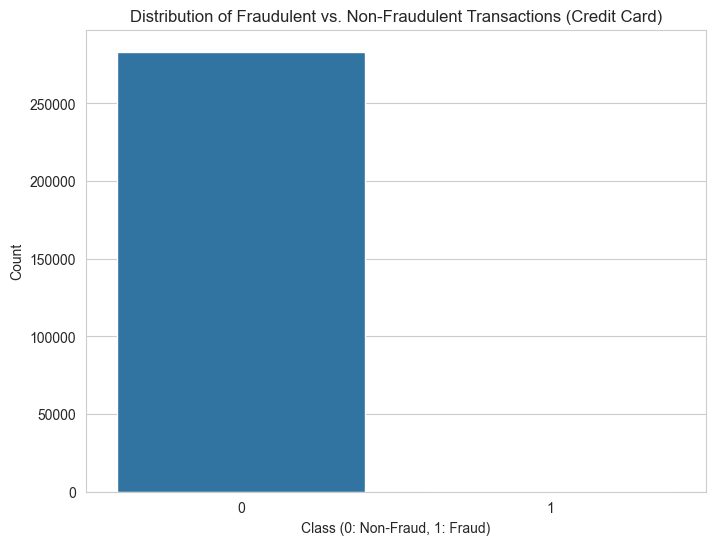

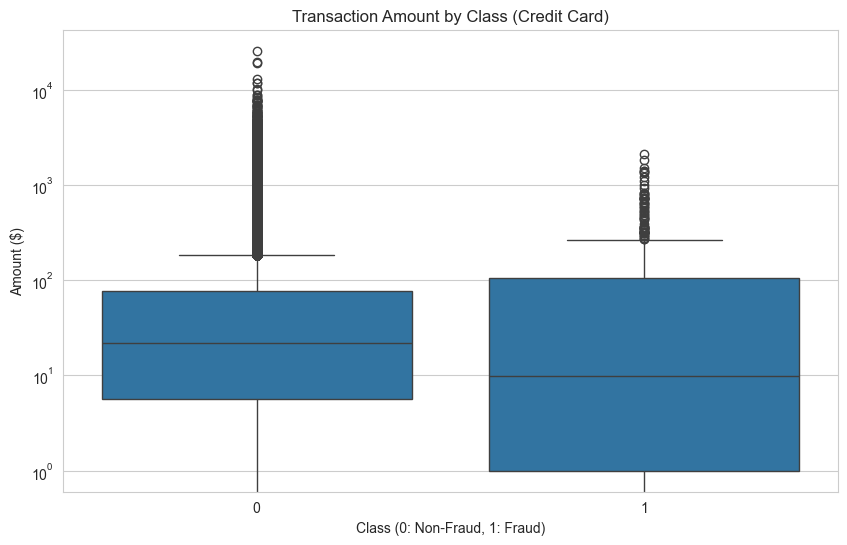

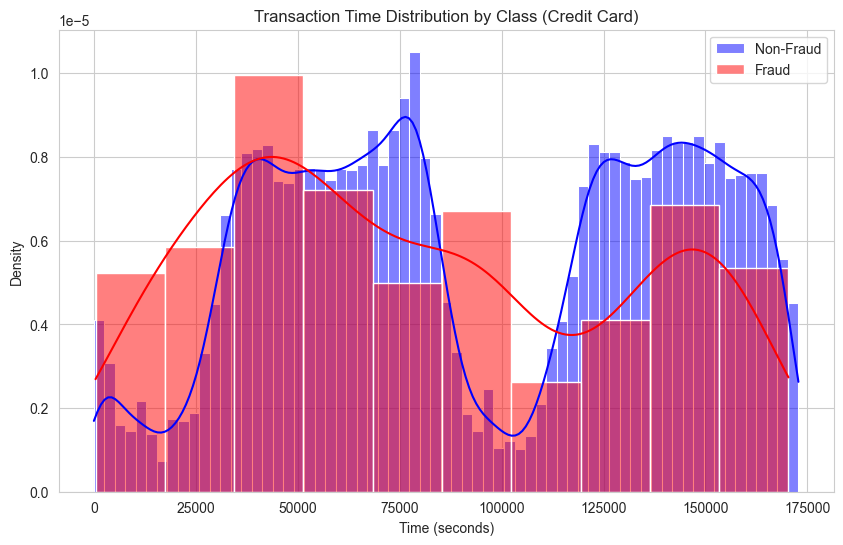

EDA for creditcard.csv completed.
Features (X_cc) shape: (283726, 30)
Target (y_cc) shape: (283726,)

Creditcard.csv data split into training and testing sets:
X_train_cc shape: (226980, 30), y_train_cc shape: (226980,)
X_test_cc shape: (56746, 30), y_test_cc shape: (56746,)
Training set class distribution:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
Test set class distribution:
Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64

Applying StandardScaler to creditcard.csv training set...
Scaling complete for creditcard.csv training set.
Creditcard.csv data scaled.

Applying SMOTE to creditcard.csv training set...
SMOTE complete for creditcard.csv training set.

Class distribution in credit card training set after SMOTE:
Class
0    226602
1    226602
Name: count, dtype: int64

Creditcard.csv transformed (scaled and resampled):
Shape of processed training data (X_train_resampled_cc): (453204, 30)
Shape of processed training labels (y_train_resampled_

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_creditcard is already loaded

print("\n--- Data Cleaning and Preprocessing for creditcard.csv ---")

# 3.1 Handle Missing Values (Check)
print("Missing values in creditcard.csv:")
print(df_creditcard.isnull().sum())
# Typically, creditcard.csv is a clean dataset with no missing values.

# 3.2 Remove Duplicates (already did this, but re-confirming here for a complete script)
initial_rows_cc = df_creditcard.shape[0]
df_creditcard.drop_duplicates(inplace=True)
print(f"Removed {initial_rows_cc - df_creditcard.shape[0]} duplicate rows from creditcard.csv.")


# 3.3 Exploratory Data Analysis (Recap/Confirmation)
# Class distribution (critical challenge)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df_creditcard)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions (Credit Card)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Distribution of 'Amount' for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df_creditcard)
plt.title('Transaction Amount by Class (Credit Card)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Amount ($)')
plt.yscale('log') # Use log scale due to skewed distribution
plt.show()

# Distribution of 'Time' for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.histplot(df_creditcard[df_creditcard['Class'] == 0]['Time'], color='blue', kde=True, stat='density', alpha=0.5, label='Non-Fraud')
sns.histplot(df_creditcard[df_creditcard['Class'] == 1]['Time'], color='red', kde=True, stat='density', alpha=0.5, label='Fraud')
plt.title('Transaction Time Distribution by Class (Credit Card)')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

print("EDA for creditcard.csv completed.")

# 3.4 Define Features (X) and Target (y)
X_cc = df_creditcard.drop('Class', axis=1)
y_cc = df_creditcard['Class']

print(f"Features (X_cc) shape: {X_cc.shape}")
print(f"Target (y_cc) shape: {y_cc.shape}")

# 3.5 Split Data into Training and Testing Sets
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

print("\nCreditcard.csv data split into training and testing sets:")
print(f"X_train_cc shape: {X_train_cc.shape}, y_train_cc shape: {y_train_cc.shape}")
print(f"X_test_cc shape: {X_test_cc.shape}, y_test_cc shape: {y_test_cc.shape}")
print(f"Training set class distribution:\n{y_train_cc.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test_cc.value_counts(normalize=True)}")

# 3.6 Scaling Numerical Features
# All V features are already PCA transformed and generally scaled, but StandardScaler can still
# help optimize some algorithms that expect zero mean and unit variance.
# 'Time' and 'Amount' definitely benefit from scaling.
numerical_features_cc = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]

scaler_cc = StandardScaler()

# Apply scaling to the training data
print("\nApplying StandardScaler to creditcard.csv training set...")
X_train_scaled_cc = scaler_cc.fit_transform(X_train_cc)
print("Scaling complete for creditcard.csv training set.")

# Apply the *fitted* scaler to the test data
X_test_scaled_cc = scaler_cc.transform(X_test_cc)

print("Creditcard.csv data scaled.")

# 3.7 Handle Class Imbalance (SMOTE for Oversampling)
# Apply SMOTE *after* scaling for credit card data
smote_cc = SMOTE(random_state=42)
print("\nApplying SMOTE to creditcard.csv training set...")
X_train_resampled_cc, y_train_resampled_cc = smote_cc.fit_resample(X_train_scaled_cc, y_train_cc)
print("SMOTE complete for creditcard.csv training set.")

print("\nClass distribution in credit card training set after SMOTE:")
print(y_train_resampled_cc.value_counts())

print("\nCreditcard.csv transformed (scaled and resampled):")
print(f"Shape of processed training data (X_train_resampled_cc): {X_train_resampled_cc.shape}")
print(f"Shape of processed training labels (y_train_resampled_cc): {y_train_resampled_cc.shape}")
print(f"Shape of processed testing data (X_test_scaled_cc): {X_test_scaled_cc.shape}")
print(f"Shape of testing labels (y_test_cc): {y_test_cc.shape}")